# Import Core Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

# Load Dataset

In [2]:
%run load_dataset.ipynb

Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 2001's data
Loading 2002's data
Finished loading


# Data Preprocessing

In [3]:
# includes wavelet denoising, normalization, PCA, LDA, SVD, etc.
%run preprocess_for_SVM.ipynb

# Function Call *

In [4]:
# denoise the signal using wavelet transform
# wavelet_output = wavelet_smooth(X_all)
# X_w = np.array(wavelet_output)

In [5]:
new_label_list = [1,2,3,0,4,5]
new_label_dict = {
    1: 'sit',
    2: 'sleep',
    3: 'stand',
    0: 'downstairs',
    4: 'upstairs',
    5: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [6]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all, y_all, subj_all, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

In [7]:
print(X_label.shape)

(6, 10)


## Show Plot for each Activity and Subject

plotting  sit


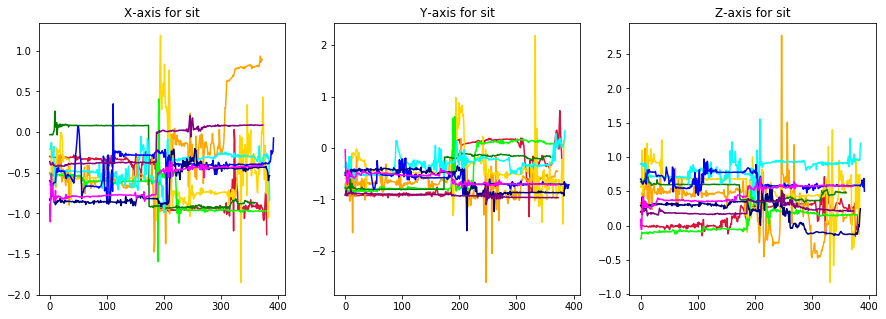

plotting  sleep


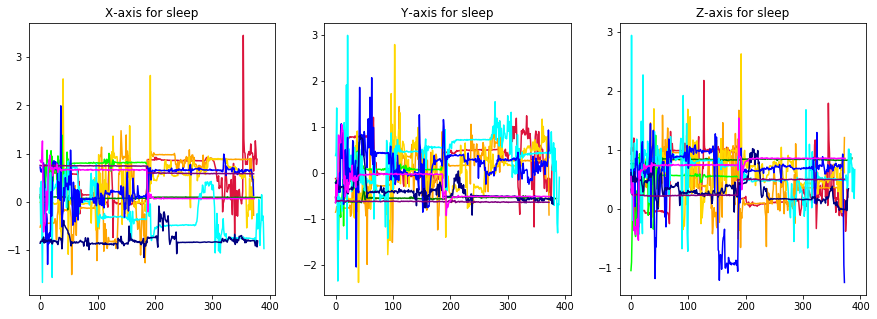

plotting  stand


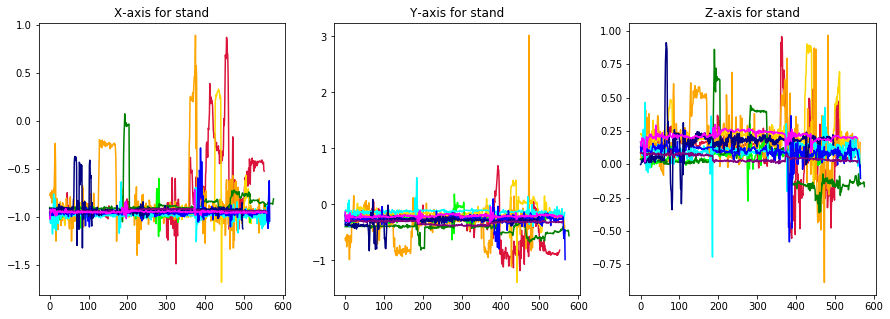

plotting  downstairs


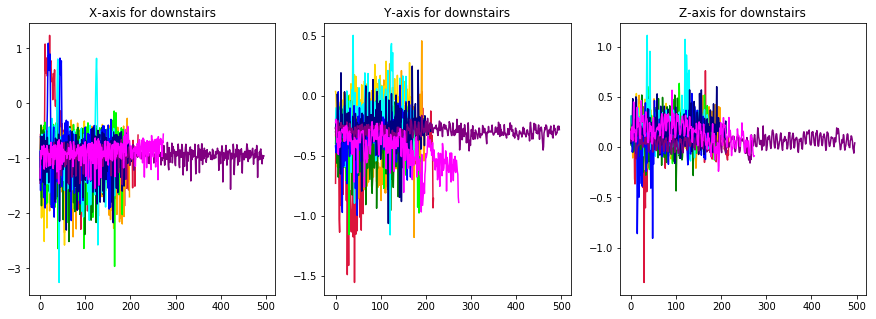

plotting  upstairs


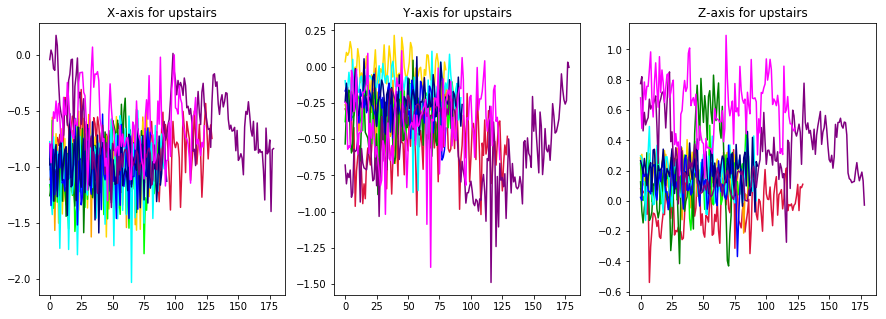

plotting  walk


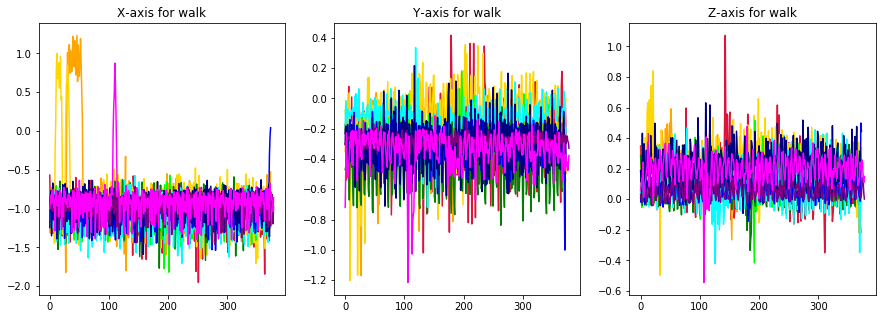

In [8]:
plot_all_label(X_label, y_all, new_label_list, new_label_dict)

In [9]:
# plot_all_label(X_norm, y_all, new_label_list, new_label_dict)

In [10]:
# calculate roll, pitch, yaw
roll, pitch, yaw = calc_rpy(X_all, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

print(rpy.shape)

(19931, 3)


PCA


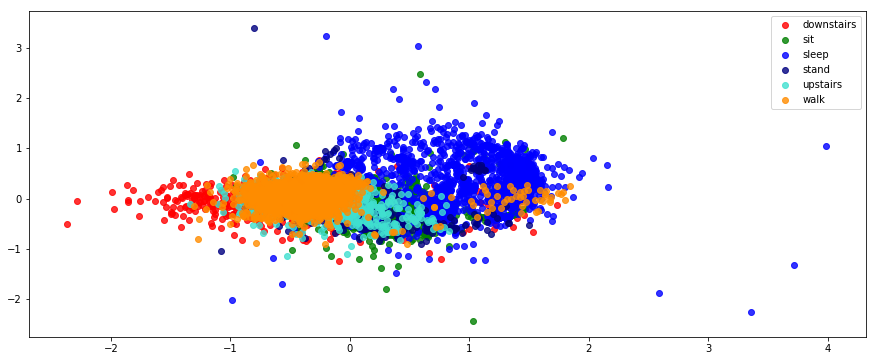

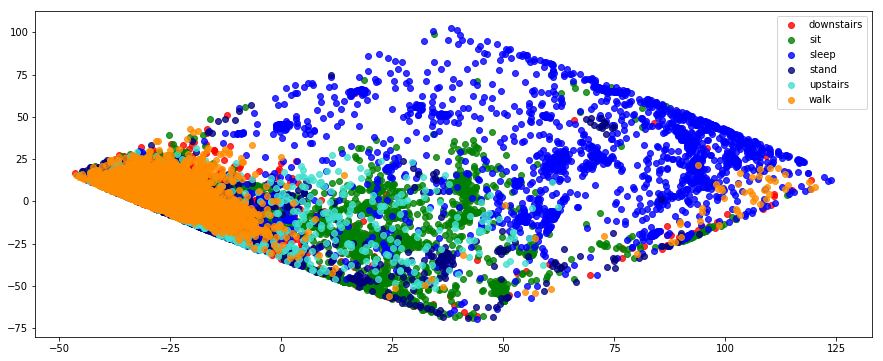

In [12]:
# apply PCA and LDA to X_norm and rpy
print("PCA")
X_pca = apply_pca(X_all, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)

In [13]:
# print("LDA")
# X_norm_lda = apply_lda(X_all, y_all, label_list)
# X_z_lda = apply_lda(X_norm_all, y_all, label_list)
# rpy_lda = apply_lda(rpy, y_all, label_list)

In [14]:
# print("SVD")
# u, s, vh = apply_svd(X_norm_all, y_all, label_list)
# u_r, s_r, vh_r = apply_svd(X_norm_all, y_all, label_list)

# print(u_r.shape, s_r.shape, vh_r.shape)
# print(s_r)

In [15]:
def make_overlapping(X, y):
    length = X.shape[0]
    X_new = []
    y_new = []
    window_length = 60  # 9.6 seconds
    
    for i in range(length):
        X_temp = []
        for j in range(window_length):
            if(i+j<length):
                X_temp.append(X[i+j])
        
        if(i+window_length-1<length):
            X_new.append(X_temp)
            y_new.append(y[i+window_length-1])
    
    return np.array(X_new), np.array(y_new)

In [16]:
def concat_xyz(X):
    X_concat = []
    for X_i in X:
        X_tp = X_i.transpose()
        X_stack = np.hstack((X_tp[0],X_tp[1],X_tp[2]))
        X_concat.append(X_stack)

    return np.array(X_concat)

In [17]:
def concat_label(X):
    X_concat = []
    for X_lb in X:
        X_temp = []
        for i in range(len(X_lb)):
            if(i==0):
                X_temp = X_lb[i]
            else:
                X_temp = np.vstack((X_temp, X_lb[i]))
                
        if(len(X_concat)==0):
            X_concat = X_temp
        else:
            X_concat = np.vstack((X_concat, X_temp))
            
    return np.array(X_concat)

In [18]:
rpy_label, y_label = label_grouping(rpy_pca, y_all, subj_all, new_label_list)

In [20]:
rpy_concat = []
y_concat = []
for i in range(len(rpy_label)):
    for j in range(len(rpy_label[i])):
        rpy_ol, y_ol = make_overlapping(np.array(rpy_label[i][j]), y_label[i][j])
        
        if(len(rpy_concat)==0):
            rpy_concat = rpy_ol
        else:
            rpy_concat = np.vstack((rpy_concat, rpy_ol))
            
        if(len(y_concat)==0):
            y_concat = y_ol
        else:
            y_concat = np.hstack((y_concat, y_ol))
        
print(rpy_concat.shape, y_concat.shape)

(16391, 60, 3) (16391,)


In [21]:
rpy_concat_xyz = concat_xyz(rpy_concat)

In [22]:
# reshape data before classification
X_svm = rpy_concat_xyz
y_svm = y_concat
# y_svm = y_svm.reshape((y_svm.shape[-1],))
y_svm = y_svm.reshape((y_svm.shape[0],))

print(X_svm.shape, y_svm.shape)

(16391, 180) (16391,)


In [36]:
rpy_ol, y_ol = make_overlapping(rpy_pca, y_all)

In [40]:
rpy_concat_ol = concat_xyz(rpy_ol)

print(rpy_concat_ol.shape)
print(y_ol.shape)

(19872, 180)
(19872,)


In [41]:
# Split training data and testing data
X_train, X_te, y_train, y_te = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

X_tr, X_test, y_tr, y_test = train_test_split(rpy_concat_ol, y_ol, test_size=0.3, random_state=42)

In [24]:
# Use SVM to classify activities
svm_model = svm_classifier(X_svm, y_svm)
print("Finished classification")

Finished classification


In [42]:
y_pred = svm_model.predict(X_test)

In [43]:
acc = accuracy_score(y_test, y_pred)

print(acc)
print(X_train.shape)
print(X_test.shape)

0.855249916135525
(11473, 180)
(5962, 180)


# Evaluation

In [29]:
%run eval_score.ipynb

In [30]:
LABELS = ['downstairs','sit','sleep','stand','upstairs','walk']

## Confusion Matrix

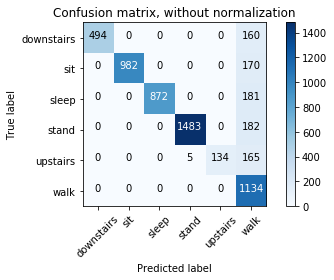

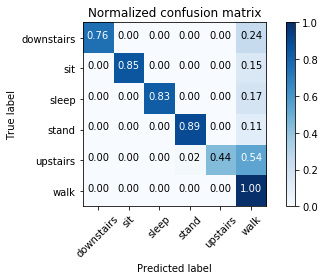

In [44]:
show_conf_matrix(y_test, y_pred, LABELS)

## Classification Report

In [45]:
show_clf_report(y_test, y_pred, LABELS)

              precision    recall  f1-score   support

  downstairs       1.00      0.76      0.86       654
         sit       1.00      0.85      0.92      1152
       sleep       1.00      0.83      0.91      1053
       stand       1.00      0.89      0.94      1665
    upstairs       1.00      0.44      0.61       304
        walk       0.57      1.00      0.73      1134

   micro avg       0.86      0.86      0.86      5962
   macro avg       0.93      0.79      0.83      5962
weighted avg       0.92      0.86      0.86      5962



### 1001
* Accuracy of original data: 0.6356

* Accuracy of PCA with original data: 0.6041

* Accuracy of PCA without original data: 0.6400

### All subjects ( test_size=0.3 )
* Accuracy of PCA without original data: 0.6542

## Colors Note

* NaN: Grey
* Stand: Red
* Sit: Green
* Sleep: Yellow
* Walk: Blue
* Walk Downstairs: Orange
* Walk Upstairs: Purple